In [4]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Parameters wanted:
   *  Mass, radius, orbital period, host star metallicity, eccentricity, equilibrium temperature.
   * Semimajor axis a may be relevant too

In [5]:
file_US="/home/bolacha/University/Project/code/data2-example/selection_US.rdb"
file_EU="/home/bolacha/University/Project/code/data2-example/selection_EU.rdb"

In [411]:
def read_file(file, removeNaN=False, params=0):
    database = np.genfromtxt(file_EU, comments="--", skip_header=4,
                            dtype=None, delimiter="\t", encoding=None)
    df = pd.DataFrame(database)
    with open(file) as f:
        columns = f.readline()
    columns = columns.replace("\n", "")
    columns = columns.split('\t')
    n = len(columns)
    df = df.iloc[:,:n]
    df.columns = columns
    df = pd.DataFrame.set_index(df,keys='obj_id_catname')
    if params != 0:
        df = df[params]
    if removeNaN == True:
        df = pd.DataFrame.dropna(df,axis=0, how='any')
    return df
           
d_US_test = read_file(file_US)
d_US_test

,db_info_name,pub_info_detectiontype,obj_phys_mass_mjup,obj_phys_msini_mjup,obj_phys_radius_rjup,obj_orb_period_day,obj_orb_a_au,obj_orb_ecc,obj_parent_phys_teff_k,obj_parent_phys_feh,obj_orb_inc_deg
obj_id_catname,,,,,,,,,,,
BD+20 2457 b,Exoplanet.eu,Radial Velocity,NaN,21.4200,NaN,379.630000,1.4500,False,False,0.15,False
2MASS J2250+2325 b,Exoplanet.eu,Imaging,30.0000,NaN,NaN,NaN,518.0000,False,False,NaN,False
CoRoT-26 b,Exoplanet.eu,Transit,0.5200,NaN,1.260,4.204740,0.0526,False,False,0.00,False
EPIC 220194974 d,Exoplanet.eu,Transit,NaN,NaN,0.146,9.757900,0.0774,False,False,NaN,False
EPIC 248545986 d,Exoplanet.eu,Transit,0.0041,NaN,0.098,10.115000,0.0685,False,False,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...
WASP-167 b,Exoplanet.eu,Transit,8.0000,NaN,1.510,2.021959,0.0365,False,False,NaN,False
WASP-25 b,Exoplanet.eu,Transit,0.5800,NaN,1.260,3.764830,0.0474,False,False,0.00,False
WD 0837+185 B,Exoplanet.eu,Radial Velocity,30.0000,25.0000,NaN,0.175000,0.0060,False,False,NaN,False


In [417]:
print(d_US_test.columns)
#param_list=['obj_phys_mass_mjup','obj_phys_radius_rjup',
 #'obj_orb_period_day','obj_parent_phys_feh','obj_orb_ecc','obj_parent_phys_teff_k']
    
d_US_test['obj_parent_phys_teff_k'] #----> eccentricity and T_eff are read as "False"

Index(['db_info_name', 'pub_info_detectiontype', 'obj_phys_mass_mjup',
       'obj_phys_msini_mjup', 'obj_phys_radius_rjup', 'obj_orb_period_day',
       'obj_orb_a_au', 'obj_orb_ecc', 'obj_parent_phys_teff_k',
       'obj_parent_phys_feh', 'obj_orb_inc_deg'],
      dtype='object')


obj_id_catname
BD+20 2457 b          False
2MASS J2250+2325 b    False
CoRoT-26 b            False
EPIC 220194974 d      False
EPIC 248545986 d      False
                      ...  
WASP-167 b            False
WASP-25 b             False
WD 0837+185 B         False
eta Cet c             False
tau Cet e             False
Name: obj_parent_phys_teff_k, Length: 4096, dtype: bool

In [418]:
#will be used for the first trial using mass and orbital period
param_MP=['obj_orb_period_day','obj_phys_mass_mjup']

#will be used for the second trial using mass, radius, temperature
param_MRP=['obj_phys_mass_mjup', 'obj_phys_radius_rjup','obj_parent_phys_teff_k']

M_US_MP, P_US_MP = d_US_MP['obj_phys_mass_mjup'], d_US_MP['obj_orb_period_day']
M_EU_MP, P_EU_MP = d_EU_MP['obj_phys_mass_mjup'], d_EU_MP['obj_orb_period_day']

In [259]:
d_US_MP=read_file(file_US,True,param_MP)
d_EU_MP=read_file(file_EU,True,param_MP)

We first aim to find three separate groups:
* Hot jupiters: P $\lesssim 7$ d, $M/M_J \leq 12$; centered around $\sim 1 M_J$ and $P \sim 3$ d; 
* Eccentric giants: $10^2 d \lesssim P \lesssim 10^4 d$; $1 \lesssim M/M_J \leq 10$.
* Ungiants: $P \leq 100 d$; $ M/M_J \lesssim 0.07$ and $R \lesssim 0.35 R_J$

$\rightarrow$ <u>Task 1:</u>  plottting mass vs period.

# mass vs orbital period

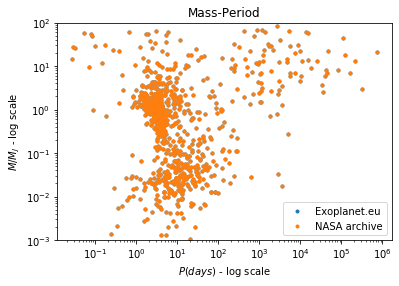

In [305]:
plt.plot(P_EU_MP, M_EU_MP,'.',label = "Exoplanet.eu")
plt.plot(P_US_MP, M_US_MP,'.',label = "NASA archive")
plt.ylabel(r"$M/M_J$ - log scale")
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r"$P (days)$ - log scale")
plt.ylim(10e-4,10e1)
plt.legend()
plt.title(r"Mass-Period")
plt.show()

Which is a first visualization for the relationship between orbital period and mass, in the full range we're studying, and also reproduces the figure in my document.

We can already see the three separate groups.

In [369]:
d_US_MP

,obj_phys_mass_mjup,obj_orb_period_day
obj_id_catname,,
CoRoT-26 b,0.5200,4.204740
EPIC 248545986 d,0.0041,10.115000
HATS-13 b,0.5430,3.044050
HAT-P-31 b,2.1710,5.005425
K2-139 b,0.3810,28.382290
...,...,...
WASP-151 b,0.3100,4.533471
WASP-163 b,1.8700,1.609688
WASP-167 b,8.0000,2.021959


[[3.62822573e+00 5.79880977e+02]
 [2.10000000e+01 7.30000000e+05]
 [1.95750000e+01 1.20098750e+05]
 [8.00000000e+00 2.67500000e+05]]
                  obj_phys_mass_mjup  obj_orb_period_day
obj_id_catname                                          
CoRoT-26 b                    0.5200            4.204740
EPIC 248545986 d              0.0041           10.115000
HATS-13 b                     0.5430            3.044050
HAT-P-31 b                    2.1710            5.005425
K2-139 b                      0.3810           28.382290
...                              ...                 ...
WASP-151 b                    0.3100            4.533471
WASP-163 b                    1.8700            1.609688
WASP-167 b                    8.0000            2.021959
WASP-25 b                     0.5800            3.764830
WD 0837+185 B                30.0000            0.175000

[898 rows x 2 columns]


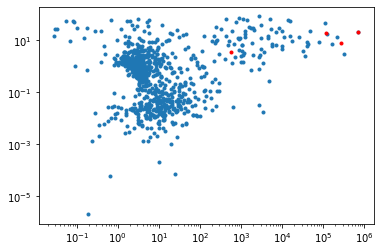

In [424]:
#R_US2
kmeans = KMeans(n_clusters=4,n_init=100).fit(d_US_MP)
centroids = kmeans.cluster_centers_
print(centroids)
print(d_US_MP)

plt.plot(P_US_MP,M_US_MP,'.')
plt.plot(centroids[:, 1],centroids[:, 0],'.',color='red')
plt.yscale('log')
plt.xscale('log')

plt.show()

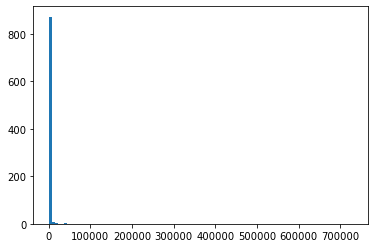

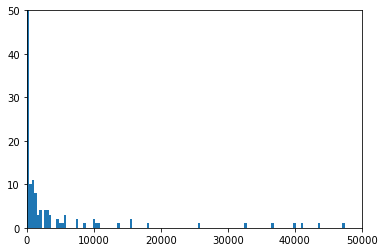

period mean value =  2519.007739507384 P max value =  730000.0 P median =  4.835396025


In [421]:
plt.hist(P_US_MP,bins=100)
plt.show()
plt.hist(P_US_MP,bins=2000)
plt.xlim(0,50000)
plt.ylim(0,50)
plt.show()
print("period mean value = ",np.mean(P_US_MP), "P max value = ", np.max(P_US_MP), "P median = ", np.median(P_US_MP))

Maybe since P is very unevenly distributed, most values are around the range of a few days yet there's a max at 730000 days. Since KMeans works on average values maybe that's shifting the centroids to the right? (Do we need to limit P?) 
(Or I'm doing this wrong)

# mass-radius-temperature

To calculate $T_{eq}$, one needs a another parameter, the planet's bond Albedo $A_B$:

$$T_{eq}=T_{star} \sqrt{\frac{R}{2 a}}(1-A_{B})^{1 / 4}$$

(Will use solene's way of calculating Teq, first need to deal with the "False" values on the stellar temperature column)

In [264]:
d_US_MRP['obj_parent_phys_teff_k']

obj_id_catname
CoRoT-26 b          False
EPIC 248545986 d    False
HATS-13 b           False
HAT-P-31 b          False
K2-139 b            False
                    ...  
LP 358-499 c        False
WASP-151 b          False
WASP-163 b          False
WASP-167 b          False
WASP-25 b           False
Name: obj_parent_phys_teff_k, Length: 802, dtype: bool

I'll first plot mass-radius.

In [263]:
d_US_MRP = read_file(file_US, True, param_MRP)
d_EU_MRP = read_file(file_EU, True, param_MRP)

M_US_MRP, R_US_MRP,T_US_star = d_US_MRP['obj_phys_mass_mjup'], d_US_MRP['obj_phys_radius_rjup'], d_US_MRP['obj_parent_phys_teff_k']
M_EU_MRP, R_EU_MRP, T_EU_star = d_EU_MRP['obj_phys_mass_mjup'], d_EU_MRP['obj_phys_radius_rjup'], d_EU_MRP['obj_parent_phys_teff_k']

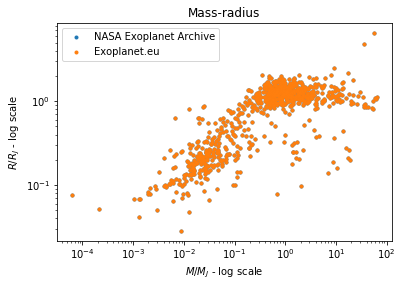

In [237]:
plt.plot(M_US_MRP, R_US_MRP, '.' ,label = "NASA Exoplanet Archive")
plt.plot(M_EU_MRP, R_EU_MRP, '.' ,label = "Exoplanet.eu")
plt.xlabel(r"$M/M_J$ - log scale")
plt.yscale('log')
plt.xscale('log')
plt.ylabel(r"$R/R_J$ - log scale")
plt.title(r"Mass-radius")
plt.legend()
plt.show()